In [1]:
import matplotlib.pyplot as plt
import os,glob,copy
import numpy as np
import seaborn as sns
import pyslha, copy, pickle
from scipy.signal import savgol_filter
import importlib
from scipy.interpolate import interp1d
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

In [2]:
def getContour(xpts,ypts,zpts,levels,ylog=False,xlog=False):
    """
    Uses pyplot tricontour method to obtain contour
    curves in a 2D plane.

    :return: A dictionary with a list of contours for each level
    """
    
    fig = plt.figure()
    x = copy.deepcopy(xpts)
    y = copy.deepcopy(ypts)
    z = copy.deepcopy(zpts)
    
    #Use log scale:
    if ylog:
        y = np.log10(y)
    if xlog:
        x = np.log10(x)
    
    CS = plt.tricontour(x,y,z,levels=levels)    
    levelPts = {}
    for il,level in enumerate(CS.levels):
        levelPts[level] = []
        c = CS.collections[il]        
        paths = c.get_paths()
        for path in paths:
            levelPts[level].append(path.vertices)
    plt.close(fig)
    
    #scale back:
    if ylog or xlog:
        for key,ptsList in levelPts.items():
            newList = []
            for pts in ptsList:
                xpts = pts[:,0]
                ypts = pts[:,1]
                if xlog:
                    xpts = 10**xpts
                if ylog:
                    ypts = 10**ypts
                newList.append(np.column_stack((xpts,ypts)))
            levelPts[key] = newList
        
    
    return levelPts

In [3]:

spec = importlib.util.spec_from_file_location("output", "./TDTM1F_x_x_x_x_y_y.py")
output_module = importlib.util.module_from_spec(spec)
# In case the module contains infs
output_module.inf = float('inf')
spec.loader.exec_module(output_module)
dataC1C1 = output_module.validationData

spec = importlib.util.spec_from_file_location("output", "./TDTM2F_x_x_x_y.py")
output_module = importlib.util.module_from_spec(spec)
# In case the module contains infs
output_module.inf = float('inf')
spec.loader.exec_module(output_module)
dataC1N1 = output_module.validationData



In [4]:
print(len(dataC1C1),len(dataC1N1))

336 336


In [5]:
dataC1C1 = sorted(dataC1C1, key = lambda pt: list(zip(pt['axes'].items())))
dataC1N1 = sorted(dataC1N1, key = lambda pt: list(zip(pt['axes'].items())))
print(len(dataC1C1),len(dataC1N1))

336 336


In [6]:
print(dataC1C1[25])

{'slhafile': 'TDTM1F_150_1.8e-16_150_150_1.8e-16_150.slha', 'axes': {'x': 150.0, 'y': 1.833e-16}, 'signal': 2.432186, 'UL': 0.037, 'condition': 0.0, 'dataset': 'SR_EW', 't': 0.09, 'nll': 318.4593, 'nll_SM': 2.058186, 'nll_min': 2.058186, 'eUL': 0.038, 'kfactor': 1.0}


In [7]:
dataComb = {}
print(len(dataC1C1))
for pt in dataC1C1:
    x = pt['axes']['x']
    y = pt['axes']['y']
    r = 0.0
    if 'signal' in pt:
        r = pt['signal']/pt['UL']
    if (x,y) in dataComb:
        print(pt)
    dataComb[(x,y)] = r
print(len(dataComb))
for pt in dataC1N1:
    x = pt['axes']['x']
    y = pt['axes']['y']
    r = 0.0
    if 'signal' in pt:
        r = pt['signal']/pt['UL']
    if (x,y) in dataComb:
        dataComb[(x,y)] += r
    else:
        dataComb[(x,y)] = r


336
336


In [8]:
print(len(dataComb))

336


In [9]:
xpts = [pt[0] for pt in dataComb.keys()]
ypts = [pt[1] for pt in dataComb.keys()]
rpts = [r for r in dataComb.values()]
excCurve = getContour(xpts,ypts,rpts,levels=[1.0],ylog=True)

/tmp/ipykernel_7507/2728983359.py:24: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  c = CS.collections[il]


In [10]:
#Official curve
excATLAS = np.genfromtxt('../orig/official_exclusion_conv.txt',
                       names=True)
excATLAS = excATLAS[np.argsort(excATLAS,order=['width_GeV'])]


/tmp/ipykernel_7507/1768970005.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(xpts,ypts,c=rpts,s=35,cmap=plt.cm.get_cmap('RdYlBu'), vmin=0., vmax=2.)


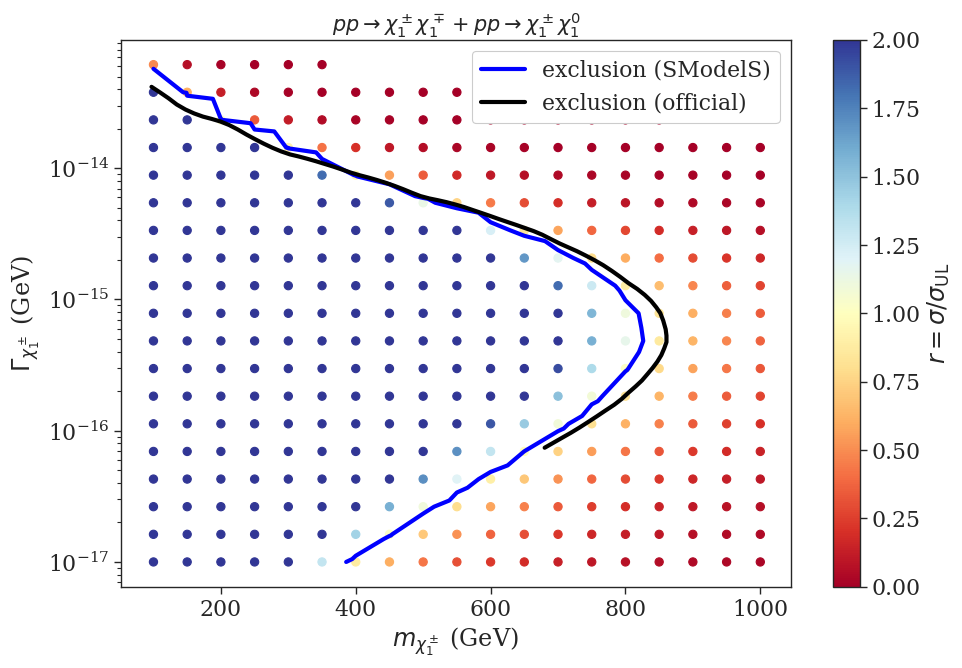

In [11]:
fig = plt.figure(figsize=(10,7))
plt.scatter(xpts,ypts,c=rpts,s=35,cmap=plt.cm.get_cmap('RdYlBu'), vmin=0., vmax=2.)
plt.plot(excCurve[1.0][0][:,0],excCurve[1.0][0][:,1],
         label='exclusion (SModelS)',
         linewidth=3,linestyle='-',color='blue')
# plt.plot(excCurve[1.2][0][:,0],excCurve[1.2][0][:,1],
#          linewidth=3,linestyle='--',color='gray',label='SModelS (LO)')
# plt.plot(excCurve[1.2][0][:,0],excCurve[1.2][0][:,1],
#          linewidth=3,linestyle='--',color='gray')


plt.plot(excATLAS['mC1_GeV'],excATLAS['width_GeV'],label='exclusion (official)',linewidth=3,linestyle='-',color='black')
# plt.plot(excATLASplus1['mC1_GeV'],excATLASplus1['width_GeV'],label=r'ATLAS $+1\sigma$',linestyle='--',linewidth=2,color='black')
plt.ylabel(r'$\Gamma_{\chi_1^\pm}$ (GeV)')
plt.xlabel(r'$m_{\chi_1^\pm}$ (GeV)')
plt.yscale('log')
plt.title(r'$p p \to \chi_1^\pm \chi_1^\mp + p p \to \chi_1^\pm \chi_1^0$',fontsize=15)
plt.tight_layout()
plt.legend(framealpha=1.0,loc='upper right')
plt.colorbar(label=r'$r=\sigma/\sigma_{\rm UL}$')
plt.savefig('combinedChannels.png')
plt.show()

/tmp/ipykernel_7507/472063211.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(xpts,6.582119569e-16/np.array(ypts),c=rpts,s=35,cmap=plt.cm.get_cmap('RdYlBu'), vmin=0., vmax=2.)


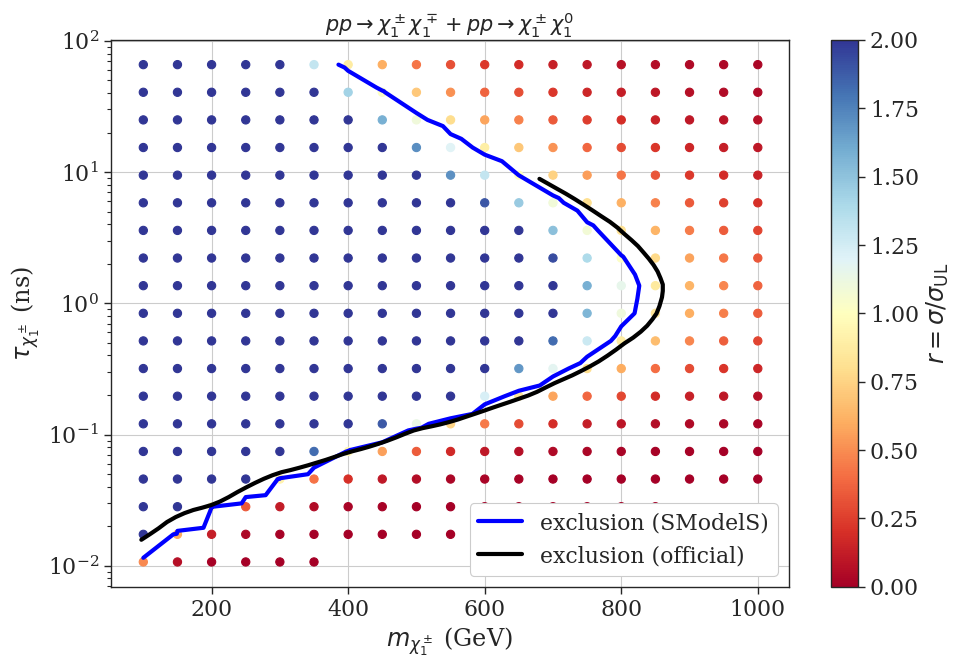

In [13]:
fig = plt.figure(figsize=(10,7))
plt.scatter(xpts,6.582119569e-16/np.array(ypts),c=rpts,s=35,cmap=plt.cm.get_cmap('RdYlBu'), vmin=0., vmax=2.)
plt.plot(excCurve[1.0][0][:,0],6.582119569e-16/(excCurve[1.0][0][:,1]),
         label='exclusion (SModelS)',
         linewidth=3,linestyle='-',color='blue')
# plt.plot(excCurve[1.2][0][:,0],excCurve[1.2][0][:,1],
#          linewidth=3,linestyle='--',color='gray',label='SModelS (LO)')
# plt.plot(excCurve[1.2][0][:,0],excCurve[1.2][0][:,1],
#          linewidth=3,linestyle='--',color='gray')


plt.plot(excATLAS['mC1_GeV'],6.582119569e-16/excATLAS['width_GeV'],label='exclusion (official)',linewidth=3,linestyle='-',color='black')
# plt.plot(excATLASplus1['mC1_GeV'],excATLASplus1['width_GeV'],label=r'ATLAS $+1\sigma$',linestyle='--',linewidth=2,color='black')
plt.ylabel(r'$\tau_{\chi_1^\pm}$ (ns)')
plt.xlabel(r'$m_{\chi_1^\pm}$ (GeV)')
plt.yscale('log')
plt.title(r'$p p \to \chi_1^\pm \chi_1^\mp + p p \to \chi_1^\pm \chi_1^0$',fontsize=15)
plt.tight_layout()
plt.legend(framealpha=1.0,loc='lower right')
plt.colorbar(label=r'$r=\sigma/\sigma_{\rm UL}$')
plt.grid()
plt.savefig('combinedChannels_tauns.png')
plt.show()